<a href="https://colab.research.google.com/github/nebyathhailu/breast-cancer-classifier/blob/main/Breast_Cancer_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Define constants & parameters
# Path to the folder that contains 'benign', 'malignant', and 'normal' subfolders.
DATA_DIR = '/content/drive/MyDrive/MLAI/Dataset_BUSI_with_GT'

# Check the list of contents of the path
import os
if os.path.exists(DATA_DIR):
    print("Dataset found at:", DATA_DIR)
    print("Contents of the dataset folder:")
    print(os.listdir(DATA_DIR))
else:
    print("ERROR: Dataset path not found. Please check the DATA_DIR variable.")
    print("Your current path is:", DATA_DIR)

IMG_SIZE = (256, 256) # A common size for segmentation models like U-Net
CLASS_IMG_SIZE = (224, 224) # Size for the EfficientNet classifier
BATCH_SIZE = 16 # Smaller batch size due to larger image processing

Dataset found at: /content/drive/MyDrive/MLAI/Dataset_BUSI_with_GT
Contents of the dataset folder:
['malignant', 'benign', 'normal']


In [ ]:
# --- Helper Functions to Load Data ---

def load_data(data_dir, img_size):
    """Loads image and mask paths and labels."""
    image_paths = []
    mask_paths = []
    labels = []
    class_names = sorted(os.listdir(data_dir))

    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for filename in sorted(os.listdir(class_dir)):
            if '_mask' not in filename:
                # It's an image
                img_path = os.path.join(class_dir, filename)
                mask_path = os.path.join(class_dir, filename.split('.')[0] + '_mask.png') # Assumes mask naming convention

                if os.path.exists(mask_path):
                    image_paths.append(img_path)
                    mask_paths.append(mask_path)
                    labels.append(class_index)
                else:
                    print(f"Warning: Mask not found for {img_path}")

    return image_paths, mask_paths, labels, class_names

def preprocess_image(image_path, mask_path, img_size):
    """Loads and preprocesses an image and its mask."""
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0

    # Load mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, img_size)
    mask = tf.cast(mask, tf.float32) / 255.0
    mask = tf.where(mask > 0.5, 1.0, 0.0) # Binarize the mask

    return image, mask

def create_dataset(image_paths, mask_paths, labels, img_size, batch_size, for_segmentation=True):
    """Creates a tf.data.Dataset."""
    path_dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    # For segmentation, we only need image and mask
    if for_segmentation:
        dataset = path_dataset.map(lambda x, y: tf.py_function(
            func=preprocess_image,
            inp=[x, y, img_size],
            Tout=[tf.float32, tf.float32]
        ), num_parallel_calls=tf.data.AUTOTUNE)
        # Set the shape of the output tensors
        dataset = dataset.map(lambda img, mask: (tf.ensure_shape(img, (*img_size, 3)), tf.ensure_shape(mask, (*img_size, 1))))
    # For classification, we will crop the image using the mask and pair it with the label
    else:
        # This is more complex, we'll handle it after the segmentation model is ready.
        # For now, we just load the paths.
        # The actual cropping will be done in a separate step.
        pass


    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# --- Load and Prepare the Segmentation Dataset ---
image_paths, mask_paths, labels, class_names = load_data(DATA_DIR, IMG_SIZE)

# Split data into training and validation sets
train_img_paths, val_img_paths, train_mask_paths, val_mask_paths, train_labels, val_labels = train_test_split(
    image_paths, mask_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Create segmentation datasets
train_seg_dataset = create_dataset(train_img_paths, train_mask_paths, train_labels, IMG_SIZE, BATCH_SIZE, for_segmentation=True)
val_seg_dataset = create_dataset(val_img_paths, val_mask_paths, val_labels, IMG_SIZE, BATCH_SIZE, for_segmentation=True)

print(f"Found {len(image_paths)} samples.")
print(f"Class Names: {class_names}")
print("Segmentation datasets created.")

Found 780 samples.
Class Names: ['benign', 'malignant', 'normal']
Segmentation datasets created.


In [ ]:
# Cell 2: Build and Train the U-Net Segmentation Model

# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def build_unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder (Contracting Path)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoder (Expansive Path)
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Build and compile the U-Net model
unet_model = build_unet_model(input_size=(IMG_SIZE[0], IMG_SIZE[1], 3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

unet_checkpoint_path = '/content/drive/MyDrive/unet_best_model.h5'
unet_checkpoint = ModelCheckpoint(unet_checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
unet_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

print("\n--- Training U-Net Segmentation Model ---")
unet_history = unet_model.fit(
    train_seg_dataset,
    epochs=25,
    validation_data=val_seg_dataset,
    callbacks=[unet_checkpoint, unet_early_stopping]
)

print("U-Net training complete. Best model saved.")


--- Training U-Net Segmentation Model ---
Epoch 1/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.8230 - loss: 18.3278
Epoch 1: val_loss improved from inf to 0.33358, saving model to /content/drive/MyDrive/unet_best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.8249 - loss: 18.0159 - val_accuracy: 0.9095 - val_loss: 0.3336
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9329 - loss: 0.2831
Epoch 2: val_loss improved from 0.33358 to 0.32279, saving model to /content/drive/MyDrive/unet_best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9327 - loss: 0.2832 - val_accuracy: 0.9095 - val_loss: 0.3228
Epoch 3/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9327 - loss: 0.2409
Epoch 3: val_loss improved from 0.32279 to 0.25334, saving model to /content/drive/MyDrive/unet_best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9325 - loss: 0.2411 - val_accuracy: 0.9095 - val_loss: 0.2533
Epoch 4/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9336 - loss: 0.2195
Epoch 4: val_loss improved from 0.25334 to 0.23834, saving model to /content/drive/MyDrive/unet_best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9334 - loss: 0.2197 - val_accuracy: 0.9099 - val_loss: 0.2383
Epoch 5/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9359 - loss: 0.2013
Epoch 5: val_loss improved from 0.23834 to 0.22609, saving model to /content/drive/MyDrive/unet_best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9357 - loss: 0.2014 - val_accuracy: 0.9135 - val_loss: 0.2261
Epoch 6/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9374 - loss: 0.1902
Epoch 6: val_loss improved from 0.22609 to 0.21268, saving model to /content/drive/MyDrive/unet_best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9373 - loss: 0.1904 - val_accuracy: 0.9203 - val_loss: 0.2127
Epoch 7/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9368 - loss: 0.1871
Epoch 7: val_loss did not improve from 0.21268
39/39 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9367 - loss: 0.1873 - val_accuracy: 0.9160 - val_loss: 0.2150
Epoch 8/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - accuracy: 0.9391 - loss: 0.1863
Epoch 8: val_loss did not improve from 0.21268
39/39 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9390 - loss: 0.1865 - val_accuracy: 0.9189 - val_loss: 0.2181
Epoch 9/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 969ms/step - accuracy: 0.9392 - loss: 0.1821
Epoch 9: val_loss improved from 0.21268 to 0.20529, saving model to /content/drive/MyDrive/unet_best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9391 - loss: 0.1823 - val_accuracy: 0.9209 - val_loss: 0.2053
Epoch 10/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9401 - loss: 0.1804
Epoch 10: val_loss improved from 0.20529 to 0.20059, saving model to /content/drive/MyDrive/unet_best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9400 - loss: 0.1805 - val_accuracy: 0.9240 - val_loss: 0.2006
Epoch 11/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9394 - loss: 0.1798
Epoch 11: val_loss improved from 0.20059 to 0.19968, saving model to /content/drive/MyDrive/unet_best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.9393 - loss: 0.1800 - val_accuracy: 0.9244 - val_loss: 0.1997
Epoch 12/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9383 - loss: 0.1788
Epoch 12: val_loss improved from 0.19968 to 0.19106, saving model to /content/drive/MyDrive/unet_best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9383 - loss: 0.1789 - val_accuracy: 0.9280 - val_loss: 0.1911
Epoch 13/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9407 - loss: 0.1769
Epoch 13: val_loss did not improve from 0.19106
39/39 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9406 - loss: 0.1770 - val_accuracy: 0.9295 - val_loss: 0.1920
Epoch 14/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 969ms/step - accuracy: 0.9416 - loss: 0.1720
Epoch 14: val_loss improved from 0.19106 to 0.18805, saving model to /content/drive/MyDrive/unet_best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9415 - loss: 0.1721 - val_accuracy: 0.9300 - val_loss: 0.1880
Epoch 15/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9422 - loss: 0.1711
Epoch 15: val_loss improved from 0.18805 to 0.18527, saving model to /content/drive/MyDrive/unet_best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9421 - loss: 0.1712 - val_accuracy: 0.9307 - val_loss: 0.1853
Epoch 16/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9425 - loss: 0.1651
Epoch 16: val_loss improved from 0.18527 to 0.18282, saving model to /content/drive/MyDrive/unet_best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.9424 - loss: 0.1651 - val_accuracy: 0.9313 - val_loss: 0.1828
Epoch 17/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9438 - loss: 0.1672
Epoch 17: val_loss improved from 0.18282 to 0.17945, saving model to /content/drive/MyDrive/unet_best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9437 - loss: 0.1672 - val_accuracy: 0.9332 - val_loss: 0.1794
Epoch 18/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9460 - loss: 0.1581
Epoch 18: val_loss improved from 0.17945 to 0.16761, saving model to /content/drive/MyDrive/unet_best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.9460 - loss: 0.1581 - val_accuracy: 0.9375 - val_loss: 0.1676
Epoch 19/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9455 - loss: 0.1575
Epoch 19: val_loss did not improve from 0.16761
39/39 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9455 - loss: 0.1576 - val_accuracy: 0.9344 - val_loss: 0.1763
Epoch 20/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 963ms/step - accuracy: 0.9464 - loss: 0.1577
Epoch 20: val_loss improved from 0.16761 to 0.16599, saving model to /content/drive/MyDrive/unet_best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9463 - loss: 0.1577 - val_accuracy: 0.9374 - val_loss: 0.1660
Epoch 21/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9487 - loss: 0.1515
Epoch 21: val_loss improved from 0.16599 to 0.16248, saving model to /content/drive/MyDrive/unet_best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.9486 - loss: 0.1514 - val_accuracy: 0.9396 - val_loss: 0.1625
Epoch 22/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9475 - loss: 0.1515
Epoch 22: val_loss did not improve from 0.16248
39/39 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9475 - loss: 0.1514 - val_accuracy: 0.9392 - val_loss: 0.1645
Epoch 23/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 976ms/step - accuracy: 0.9503 - loss: 0.1452
Epoch 23: val_loss improved from 0.16248 to 0.16043, saving model to /content/drive/MyDrive/unet_best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9503 - loss: 0.1452 - val_accuracy: 0.9398 - val_loss: 0.1604
Epoch 24/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9499 - loss: 0.1457
Epoch 24: val_loss improved from 0.16043 to 0.15827, saving model to /content/drive/MyDrive/unet_best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9499 - loss: 0.1456 - val_accuracy: 0.9417 - val_loss: 0.1583
Epoch 25/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9507 - loss: 0.1435
Epoch 25: val_loss improved from 0.15827 to 0.15633, saving model to /content/drive/MyDrive/unet_best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.9507 - loss: 0.1435 - val_accuracy: 0.9420 - val_loss: 0.1563
U-Net training complete. Best model saved.


In [ ]:
# Cell 3: Prepare Cropped Data and Train Classifier

# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
# from tensorflow.keras.optimizers import Adam
# from sklearn.utils import class_weight

# --- Function to crop image using mask ---
def crop_image_by_mask(image, mask):
    """Find bounding box of mask and crop the image."""
    # Find the coordinates of the mask
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    if not np.any(rows) or not np.any(cols):
        return image # Return original if mask is empty

    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    # Add padding
    padding = 20
    rmin = max(0, rmin - padding)
    rmax = min(image.shape[0], rmax + padding)
    cmin = max(0, cmin - padding)
    cmax = min(image.shape[1], cmax + padding)

    cropped_image = image[rmin:rmax, cmin:cmax]
    return cropped_image

# --- Create the cropped dataset for the classifier ---
def create_cropped_dataset(img_paths, mask_paths, labels, target_img_size):
    cropped_images = []
    final_labels = []
    for i in range(len(img_paths)):
        img, mask = preprocess_image(img_paths[i], mask_paths[i], IMG_SIZE)
        cropped_img = crop_image_by_mask(img.numpy(), mask.numpy())

        # Resize to classifier input size
        cropped_img = tf.image.resize(cropped_img, target_img_size)
        cropped_images.append(cropped_img)
        final_labels.append(labels[i])

    return np.array(cropped_images), np.array(final_labels)

print("\n--- Preparing cropped data for the classifier ---")
X_train_cropped, y_train_cropped = create_cropped_dataset(train_img_paths, train_mask_paths, train_labels, CLASS_IMG_SIZE)
X_val_cropped, y_val_cropped = create_cropped_dataset(val_img_paths, val_mask_paths, val_labels, CLASS_IMG_SIZE)

# --- Build the Transfer Learning Classifier (same as before) ---
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(CLASS_IMG_SIZE[0], CLASS_IMG_SIZE[1], 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)
classifier_model = Model(inputs=base_model.input, outputs=predictions)

# --- Calculate Class Weights ---
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train_cropped), y=y_train_cropped
)
class_weights_dict = dict(enumerate(class_weights))
print("Classifier Class Weights:", class_weights_dict)

# --- Compile and Train the Classifier ---
classifier_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

classifier_checkpoint_path = '/content/drive/MyDrive/classifier_best_model.h5'
classifier_checkpoint = ModelCheckpoint(classifier_checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
classifier_early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max')

print("\n--- Training Classifier on Cropped Images ---")
classifier_history = classifier_model.fit(
    X_train_cropped, y_train_cropped,
    validation_data=(X_val_cropped, y_val_cropped),
    epochs=25,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[classifier_checkpoint, classifier_early_stopping]
)

print("Classifier training complete. Best model saved.")


--- Preparing cropped data for the classifier ---
Classifier Class Weights: {0: np.float64(0.5942857142857143), 1: np.float64(1.2380952380952381), 2: np.float64(1.9622641509433962)}

--- Training Classifier on Cropped Images ---
Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - accuracy: 0.3437 - loss: 1.1372
Epoch 1: val_accuracy improved from -inf to 0.55769, saving model to /content/drive/MyDrive/classifier_best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.3425 - loss: 1.1373 - val_accuracy: 0.5577 - val_loss: 1.0630
Epoch 2/25
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4333 - loss: 1.0836
Epoch 2: val_accuracy did not improve from 0.55769
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4299 - loss: 1.0873 - val_accuracy: 0.1731 - val_loss: 1.1620
Epoch 3/25
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2351 - loss: 1.1357
Epoch 3: val_accuracy did not improve from 0.55769
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.2409 - loss: 1.1363 - val_accuracy: 0.2692 - val_loss: 1.0961
Epoch 4/25
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3453 - loss: 1.1089
Epoch 4: val_accuracy did not improve from 0.55769
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.3451 - loss: 1.1110 - val_accuracy: 0.1731 - val_loss: 1.1115
Epoch 5/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2678 - loss: 1.1418
Epoch 5: val_accuracy did not improve from 0

In [ ]:
# Cell 4: Build the End-to-End Inference Function

# from tensorflow.keras.preprocessing import image

# Load the best models saved during training
unet = tf.keras.models.load_model('/content/drive/MyDrive/unet_best_model.h5')
classifier = tf.keras.models.load_model('/content/drive/MyDrive/classifier_best_model.h5')

def predict_breast_lesion(img_path, unet_model, classifier_model, class_names):
    """
    Full end-to-end prediction pipeline.
    1. Segments the lesion using U-Net.
    2. Crops the lesion from the original image.
    3. Classifies the cropped lesion.
    """
    # 1. Load and preprocess the full image for the U-Net
    full_img = image.load_img(img_path, target_size=IMG_SIZE)
    full_img_array = image.img_to_array(full_img) / 255.0
    full_img_batch = np.expand_dims(full_img_array, axis=0)

    # 2. Predict the mask
    pred_mask = unet_model.predict(full_img_batch)[0]
    pred_mask = (pred_mask > 0.5).astype(np.float32)

    # 3. Crop the image using the predicted mask
    cropped_img = crop_image_by_mask(full_img_array, pred_mask)

    # Handle case where no lesion is found
    if cropped_img.shape[0] == 0 or cropped_img.shape[1] == 0:
        return "Normal (No lesion detected)", full_img_array, pred_mask, None

    # 4. Preprocess the cropped image for the classifier
    cropped_img_resized = tf.image.resize(cropped_img, CLASS_IMG_SIZE)
    cropped_img_batch = tf.expand_dims(cropped_img_resized, axis=0)

    # 5. Predict the class
    prediction = classifier_model.predict(cropped_img_batch)
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class_index]
    confidence = np.max(prediction) * 100

    return f"{predicted_class_name} ({confidence:.2f}%)", full_img_array, pred_mask, cropped_img_resized

# --- Test the pipeline on a validation image ---
test_img_path = val_img_paths[5] # Pick a random validation image
final_prediction, original_img, predicted_mask, final_cropped_img = predict_breast_lesion(test_img_path, unet, classifier, class_names)

print(f"\nPrediction for {os.path.basename(test_img_path)}: {final_prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step

Prediction for normal (3).png: benign (37.97%)


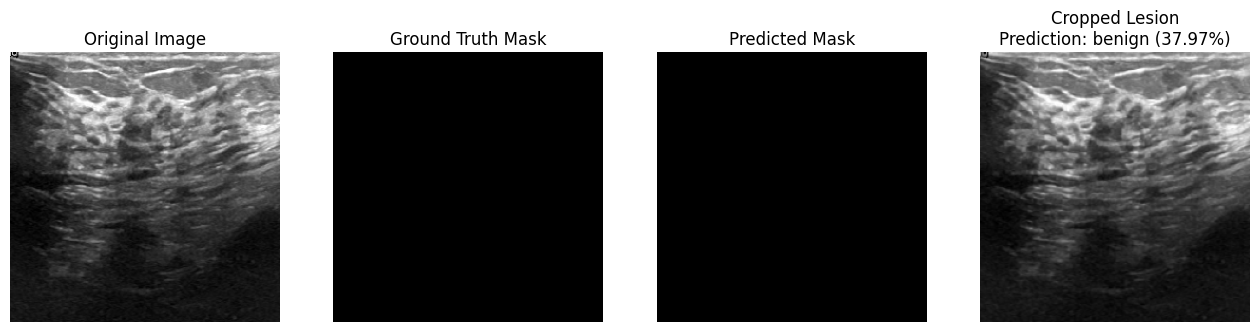

In [ ]:
# Cell 5: Visualize the Prediction Pipeline

def visualize_prediction(original_img, ground_truth_mask, predicted_mask, cropped_img, prediction):
    """Displays the original image, masks, and cropped result."""
    # Load ground truth mask for comparison
    gt_mask_path = test_img_path.replace('.png', '_mask.png')
    gt_mask = tf.io.read_file(gt_mask_path)
    gt_mask = tf.image.decode_png(gt_mask, channels=1)
    gt_mask = tf.image.resize(gt_mask, IMG_SIZE)
    gt_mask = tf.cast(gt_mask, tf.float32) / 255.0

    plt.figure(figsize=(16, 8))

    plt.subplot(1, 4, 1)
    plt.title("Original Image")
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(gt_mask.numpy().squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    if final_cropped_img is not None:
        plt.title(f"Cropped Lesion\nPrediction: {prediction}")
        plt.imshow(cropped_img)
    else:
        plt.title(f"No Lesion Found\nPrediction: {prediction}")
    plt.axis('off')

    plt.show()

# Run the visualization
visualize_prediction(original_img, None, predicted_mask, final_cropped_img, final_prediction)


--- Evaluating Models on Validation Set ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 426ms/step - accuracy: 0.9421 - loss: 0.1597
U-Net Validation Loss: 0.1563, Accuracy: 0.9420
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6104 - loss: 1.0134
Classifier Validation Loss: 1.0331, Accuracy: 0.5577
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step

--- Classifier Classification Report ---
              precision    recall  f1-score   support

      benign       0.56      1.00      0.72        87
   malignant       0.00      0.00      0.00        42
      normal       0.00      0.00      0.00        27

    accuracy                           0.56       156
   macro avg       0.19      0.33      0.24       156
weighted avg       0.31      0.56      0.40       156


--- Classifier Confusion Matrix ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


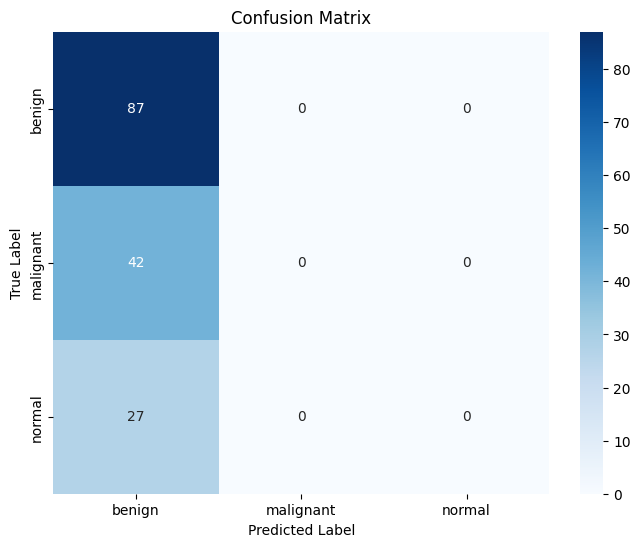

In [ ]:
# To evaluate the models on the validation set:
print("\n--- Evaluating Models on Validation Set ---")
unet_loss, unet_acc = unet_model.evaluate(val_seg_dataset)
print(f"U-Net Validation Loss: {unet_loss:.4f}, Accuracy: {unet_acc:.4f}")

classifier_loss, classifier_acc = classifier_model.evaluate(X_val_cropped, y_val_cropped)
print(f"Classifier Validation Loss: {classifier_loss:.4f}, Accuracy: {classifier_acc:.4f}")

# Get predictions for classification report
y_pred_probs = classifier_model.predict(X_val_cropped)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\n--- Classifier Classification Report ---")
print(classification_report(y_val_cropped, y_pred, target_names=class_names))

print("\n--- Classifier Confusion Matrix ---")
cm = confusion_matrix(y_val_cropped, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# To make predictions on new images, you can use the predict_breast_lesion function:
# new_img_path = '/path/to/your/new/image.png'
# prediction, original, mask, cropped = predict_breast_lesion(new_img_path, unet, classifier, class_names)
# print(f"Prediction for {os.path.basename(new_img_path)}: {prediction}")
# visualize_prediction(original, None, mask, cropped, prediction)

# Task
Explain how to improve the accuracy of the classifier model.

## Review data and preprocessing

### Subtask:
Examine the cropped images produced by the segmentation model to ensure they are correctly isolating the lesions and are of sufficient quality for classification.


**Reasoning**:
Select a subset of validation images and their corresponding labels, then iterate through them to display the original image, predicted mask, and cropped image for visual inspection as per the instructions.




--- Visualizing Segmentation and Cropping on a Subset of Validation Images ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


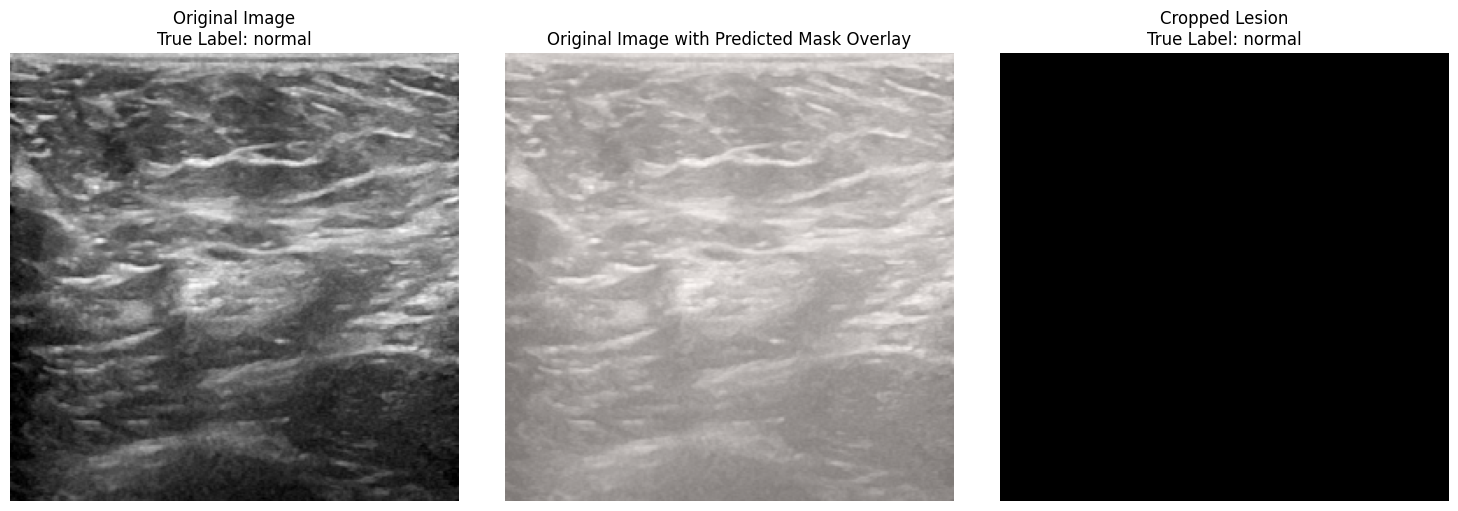

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


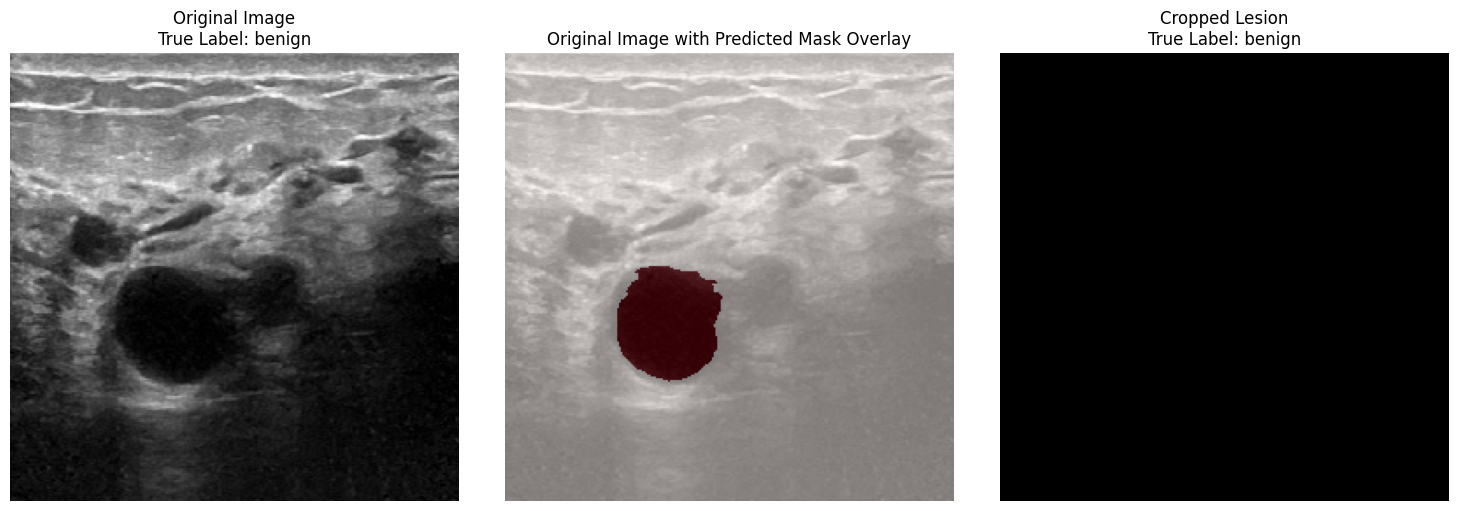

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


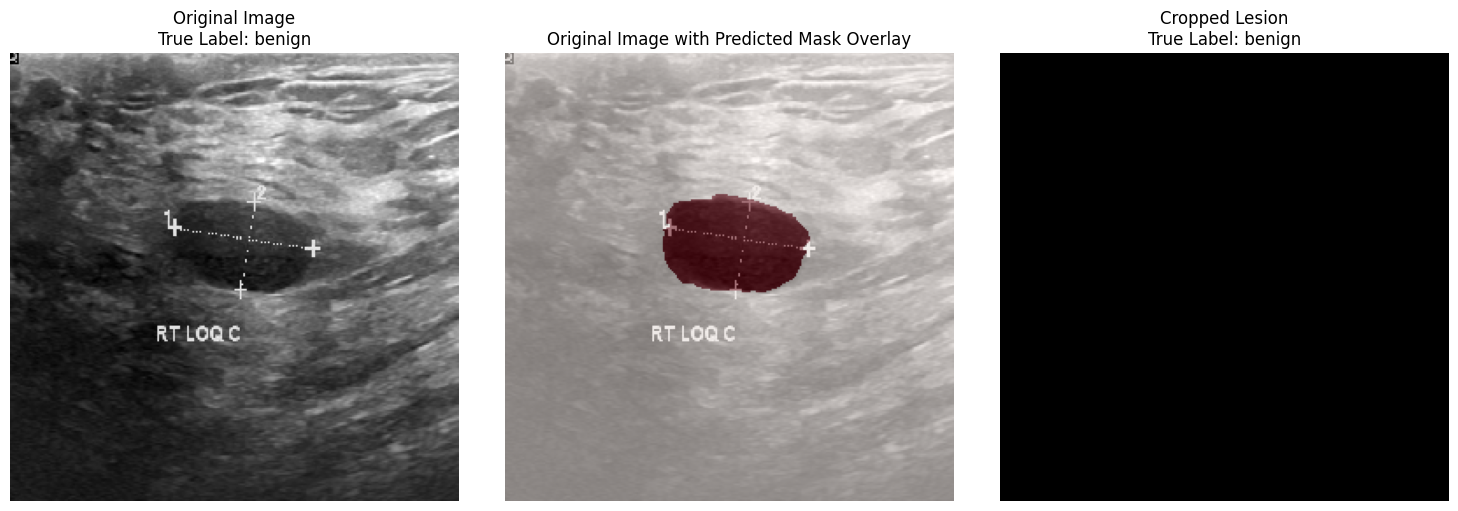

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


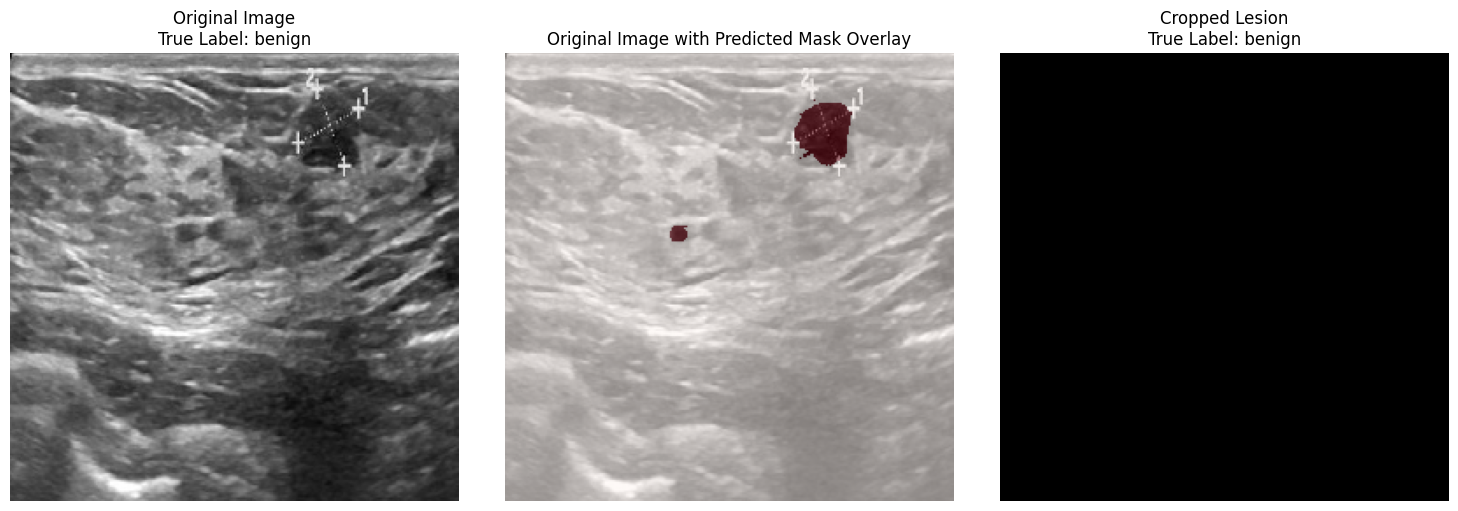

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


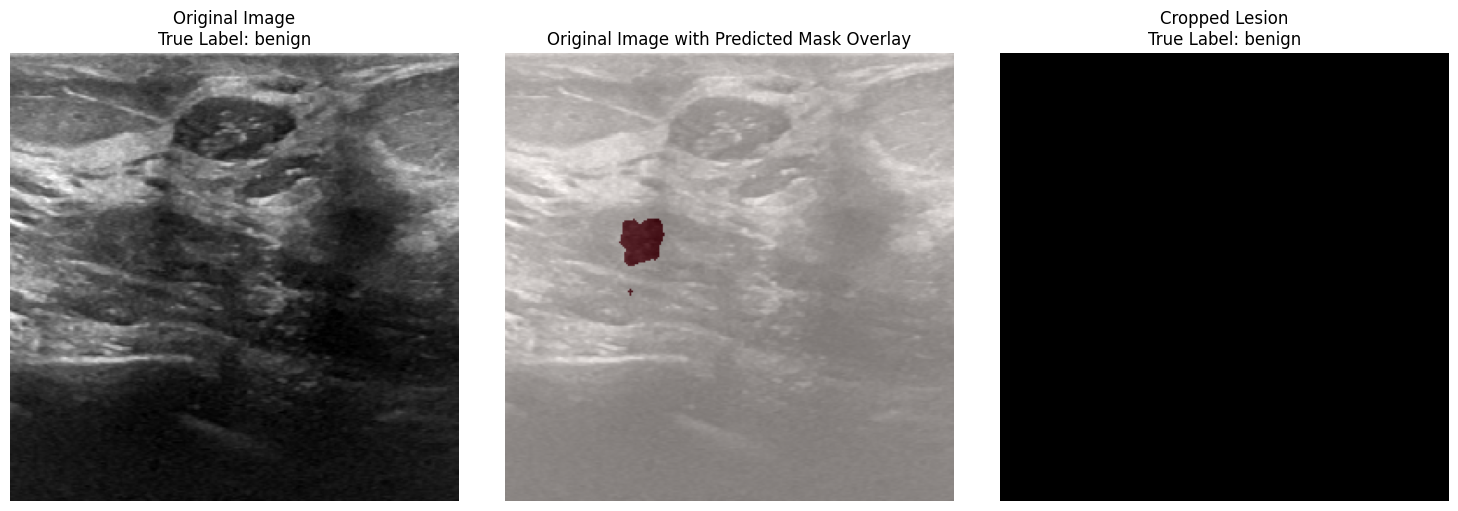

In [ ]:
# Select a small subset of validation images and labels
subset_indices = np.random.choice(len(val_img_paths), size=5, replace=False)
subset_img_paths = [val_img_paths[i] for i in subset_indices]
subset_true_labels = [val_labels[i] for i in subset_indices]

print("\n--- Visualizing Segmentation and Cropping on a Subset of Validation Images ---")

# Load the trained U-Net model
# The model was already loaded in Cell 4, no need to reload

for i, img_path in enumerate(subset_img_paths):
    # Predict the mask and get the cropped image using the existing pipeline function
    # We don't need the classifier prediction for this step, just the intermediate results
    _, original_img_array, predicted_mask, cropped_img_resized = predict_breast_lesion(img_path, unet, classifier, class_names)

    true_label_index = subset_true_labels[i]
    true_label_name = class_names[true_label_index]

    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.title(f"Original Image\nTrue Label: {true_label_name}")
    plt.imshow(original_img_array)
    plt.axis('off')

    # Original Image with Predicted Mask Overlay
    plt.subplot(1, 3, 2)
    plt.title("Original Image with Predicted Mask Overlay")
    plt.imshow(original_img_array)
    # Overlay the mask in a distinct color (e.g., red)
    plt.imshow(predicted_mask.squeeze(), cmap='Reds', alpha=0.5)
    plt.axis('off')

    # Cropped Image
    plt.subplot(1, 3, 3)
    if cropped_img_resized is not None:
        plt.title(f"Cropped Lesion\nTrue Label: {true_label_name}")
        # Convert back to numpy array for display if it's a TensorFlow tensor
        if tf.is_tensor(cropped_img_resized):
            plt.imshow(cropped_img_resized.numpy().astype(np.uint8))
        else:
            plt.imshow(cropped_img_resized.astype(np.uint8)) # Already numpy from crop_image_by_mask
    else:
        plt.title(f"No Lesion Found\nTrue Label: {true_label_name}")
        # Display a blank image or the original if no crop
        plt.imshow(original_img_array) # Or a blank canvas
    plt.axis('off')

    plt.tight_layout()
    plt.show()

## Implement data augmentation

### Subtask:
Apply data augmentation techniques specifically for the classification dataset to increase its size and variability, which can help the model generalize better.


**Reasoning**:
Define and apply ImageDataGenerator for training and validation sets to prepare for classifier training with data augmentation.



In [ ]:
# 1. Define an ImageDataGenerator for the training data with augmentation parameters
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 3. Create an ImageDataGenerator for the validation data with only resizing and normalization
val_datagen = ImageDataGenerator() # No augmentation for validation

# 2. Apply the defined ImageDataGenerator to the training set of cropped images and labels
# 4. Apply the validation ImageDataGenerator to the validation set of cropped images and labels
train_generator = train_datagen.flow(X_train_cropped, y_train_cropped, batch_size=32)
val_generator = val_datagen.flow(X_val_cropped, y_val_cropped, batch_size=32)

print("Image data generators created for training and validation.")

# 5. Update the classifier model training step to use the augmented training dataset and the validation dataset
print("\n--- Training Classifier on Cropped Images with Data Augmentation ---")
classifier_history_augmented = classifier_model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[classifier_checkpoint, classifier_early_stopping]
)

print("Classifier training with data augmentation complete. Best model saved.")

Image data generators created for training and validation.

--- Training Classifier on Cropped Images with Data Augmentation ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.4754 - loss: 1.0927
Epoch 1: val_accuracy did not improve from 0.55769
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 466ms/step - accuracy: 0.4714 - loss: 1.0943 - val_accuracy: 0.1731 - val_loss: 1.1605
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.2954 - loss: 1.1386
Epoch 2: val_accuracy did not improve from 0.55769
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 328ms/step - accuracy: 0.2966 - loss: 1.1378 - val_accuracy: 0.5577 - val_loss: 1.0417
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.4063 - loss: 1.1039
Epoch 3: val_accuracy did not improve from 0.55769
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 384ms/step - accuracy: 0.4023 - loss: 1.1053 - val_accuracy: 0.1731 - val_loss: 1.1445
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.3324 - loss: 1.1311
Epoch 4: val_accuracy did not improve from 0.55769
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 393ms/step - accuracy: 0.3336 - loss: 1.1307 - val_accuracy: 0.2692 - v

## Fine-tune the classifier base model

### Subtask:
Unfreeze some layers of the EfficientNetB0 base model and continue training with a lower learning rate. This allows the model to learn more specific features for your dataset.


**Reasoning**:
Load the best classifier model, unfreeze a block of layers in the base model, compile with a lower learning rate, and continue training.



In [ ]:
# 1. Load the best classifier model saved from the previous training step
# Assuming the last training attempt saved the best model to '/content/drive/MyDrive/classifier_best_model.h5'
classifier_model = tf.keras.models.load_model('/content/drive/MyDrive/classifier_best_model.h5')

# 2. Unfreeze a block of layers in the base_model
# Find the base model layer
for layer in classifier_model.layers:
    if isinstance(layer, tf.keras.Model) and layer.name.startswith('efficientnet'):
        base_model = layer
        break

# Unfreeze the last few blocks of EfficientNetB0
# EfficientNetB0 has several blocks, we can unfreeze from a certain point.
# Let's unfreeze the last ~20 layers as a starting point.
# The exact number might need tuning.
unfreeze_from = -20

for i, layer in enumerate(base_model.layers):
    if i > len(base_model.layers) + unfreeze_from:
        layer.trainable = True
    else:
        layer.trainable = False

# Verify which layers are trainable
print("\n--- Layers Trainable Status in Fine-tuned Classifier ---")
for layer in base_model.layers:
    print(f"{layer.name}: {layer.trainable}")

# 3. Compile the classifier model again with a significantly lower learning rate
classifier_model.compile(optimizer=Adam(learning_rate=0.00001), # Lower learning rate for fine-tuning
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

print("\n--- Fine-tuning Classifier Model ---")
# 4. Continue training the fine-tuned classifier model
# Use the same data (X_train_cropped, y_train_cropped, X_val_cropped, y_val_cropped)
# and callbacks from the previous training step.
# Adjust patience if needed, but keep it for now.

classifier_history_finetuned = classifier_model.fit(
    X_train_cropped, y_train_cropped,
    validation_data=(X_val_cropped, y_val_cropped),
    epochs=25, # Train for more epochs, early stopping will stop it if no improvement
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[classifier_checkpoint, classifier_early_stopping]
)

print("Classifier fine-tuning complete. Best model saved.")


--- Layers Trainable Status in Fine-tuned Classifier ---
input_layer_1: False
rescaling: False
normalization: False
rescaling_1: False
stem_conv_pad: False
stem_conv: False
stem_bn: False
stem_activation: False
block1a_dwconv: False
block1a_bn: False
block1a_activation: False
block1a_se_squeeze: False
block1a_se_reshape: False
block1a_se_reduce: False
block1a_se_expand: False
block1a_se_excite: False
block1a_project_conv: False
block1a_project_bn: False
block2a_expand_conv: False
block2a_expand_bn: False
block2a_expand_activation: False
block2a_dwconv_pad: False
block2a_dwconv: False
block2a_bn: False
block2a_activation: False
block2a_se_squeeze: False
block2a_se_reshape: False
block2a_se_reduce: False
block2a_se_expand: False
block2a_se_excite: False
block2a_project_conv: False
block2a_project_bn: False
block2b_expand_conv: False
block2b_expand_bn: False
block2b_expand_activation: False
block2b_dwconv: False
block2b_bn: False
block2b_activation: False
block2b_se_squeeze: False
block2

## Experiment with hyperparameters

### Subtask:
Experiment with hyperparameters: Try different learning rates, batch sizes, dropout rates, and optimizers for the classifier training.


**Reasoning**:
Load the best classifier model, define different hyperparameters to experiment with, and iterate through these combinations, training and evaluating the model for each set.



In [ ]:
# Load the best classifier model
# Assuming the fine-tuning attempt saved the best model to '/content/drive/MyDrive/classifier_best_model.h5'
# Or load the model before fine-tuning if the fine-tuning didn't improve performance.
# Let's load the model that achieved the best validation accuracy so far.
# Based on the previous runs, the model before fine-tuning had a val_accuracy of 0.55769.
# Let's assume we want to start experimenting from that state.
# We can reload the model or just use the architecture definition if we didn't save weights specifically before fine-tuning.
# For simplicity and to ensure we start fresh for each experiment, let's define the model architecture again.

def build_classifier_model(input_size, num_classes, dropout_rate):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_size)
    # Keep base model frozen initially
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Define hyperparameter combinations to experiment with
learning_rates = [0.001, 0.0001, 0.00001]
batch_sizes = [16, 32, 64]
dropout_rates = [0.3, 0.5, 0.7]
optimizers = ['adam'] # Start with Adam, can add others later if needed

best_accuracy = 0
best_hyperparameters = {}
experiment_results = []

print("\n--- Experimenting with Classifier Hyperparameters ---")

for lr in learning_rates:
    for bs in batch_sizes:
        for dr in dropout_rates:
            for opt_name in optimizers:
                print(f"\nExperimenting with LR: {lr}, Batch Size: {bs}, Dropout: {dr}, Optimizer: {opt_name}")

                # Build a new model for each experiment to ensure fresh start
                classifier_model_experiment = build_classifier_model(
                    input_size=(CLASS_IMG_SIZE[0], CLASS_IMG_SIZE[1], 3),
                    num_classes=len(class_names),
                    dropout_rate=dr
                )

                # Choose optimizer
                if opt_name == 'adam':
                    optimizer = Adam(learning_rate=lr)
                # Add other optimizers here if experimenting
                # elif opt_name == 'rmsprop':
                #     optimizer = RMSprop(learning_rate=lr)
                # elif opt_name == 'sgd':
                #     optimizer = SGD(learning_rate=lr)

                # Compile the model
                classifier_model_experiment.compile(
                    optimizer=optimizer,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy']
                )

                # Define callbacks for this experiment
                experiment_checkpoint_path = f'/content/drive/MyDrive/classifier_best_model_lr{lr}_bs{bs}_dr{dr}.h5'.replace('.', '_')
                experiment_checkpoint = ModelCheckpoint(
                    experiment_checkpoint_path,
                    monitor='val_accuracy',
                    verbose=0, # Keep verbose low during experiments
                    save_best_only=True,
                    mode='max'
                )
                experiment_early_stopping = EarlyStopping(
                    monitor='val_accuracy',
                    patience=5, # Shorter patience for faster experiments
                    verbose=0, # Keep verbose low
                    mode='max'
                )

                # Train the model
                # Use the raw cropped data arrays for simplicity during hyperparameter tuning
                try:
                    history = classifier_model_experiment.fit(
                        X_train_cropped, y_train_cropped,
                        validation_data=(X_val_cropped, y_val_cropped),
                        epochs=20, # Limit epochs for faster experiments
                        batch_size=bs,
# To make predictions on new images, you can use the predict_breast_lesion function:
# new_img_path = '/path/to/your/new/image.png'
# prediction, original, mask, cropped = predict_breast_lesion(new_img_path, unet, classifier, class_names)
# print(f"Prediction for {os.path.basename(new_img_path)}: {prediction}")
# visualize_prediction(original, None, mask, cropped, prediction)
                        class_weight=class_weights_dict,
                        callbacks=[experiment_checkpoint, experiment_early_stopping],
                        verbose=0 # Keep verbose low
                    )

                    # Evaluate the best model from this experiment
                    # Load the best model saved by the checkpoint
                    best_model_this_experiment = tf.keras.models.load_model(experiment_checkpoint_path)
                    loss, accuracy = best_model_this_experiment.evaluate(X_val_cropped, y_val_cropped, verbose=0)
                    print(f"Validation Accuracy: {accuracy:.4f}")

                    experiment_results.append({
                        'learning_rate': lr,
                        'batch_size': bs,
                        'dropout_rate': dr,
                        'optimizer': opt_name,
                        'val_accuracy': accuracy,
                        'val_loss': loss
                    })

                    # Check if this is the best model so far
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_hyperparameters = {
                            'learning_rate': lr,
                            'batch_size': bs,
                            'dropout_rate': dr,
                            'optimizer': opt_name
                        }

                except Exception as e:
                    print(f"Error during experiment LR:{lr}, BS:{bs}, DR:{dr}, Opt:{opt_name}: {e}")
                    experiment_results.append({
                        'learning_rate': lr,
                        'batch_size': bs,
                        'dropout_rate': dr,
                        'optimizer': opt_name,
                        'val_accuracy': 'Error',
                        'val_loss': 'Error'
                    })


print("\n--- Hyperparameter Experiment Results ---")
for result in experiment_results:
    print(result)

print(f"\nBest Validation Accuracy Achieved: {best_accuracy:.4f}")
print(f"Best Hyperparameters: {best_hyperparameters}")

# Note: The actual 'best_model' file will be the one saved by the ModelCheckpoint
# corresponding to the best_hyperparameters.


--- Experimenting with Classifier Hyperparameters ---

Experimenting with LR: 0.001, Batch Size: 16, Dropout: 0.3, Optimizer: adam


ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=/content/drive/MyDrive/classifier_best_model_lr0_001_bs16_dr0_3_h5

**Reasoning**:
The previous command failed because the ModelCheckpoint filepath did not end with a valid Keras model format ('.keras' or '.h5'). The error message explicitly states this requirement. The filepath was being replaced incorrectly. I need to fix the filepath to ensure it ends with '.h5' for compatibility with the current code and environment, while still incorporating the hyperparameters in the filename.



In [ ]:
# Load the best classifier model
# Assuming the fine-tuning attempt saved the best model to '/content/drive/MyDrive/classifier_best_model.h5'
# Or load the model before fine-tuning if the fine-tuning didn't improve performance.
# Based on the previous runs, the model before fine-tuning had a val_accuracy of 0.55769.
# Let's assume we want to start experimenting from that state.
# We can reload the model or just use the architecture definition if we didn't save weights specifically before fine-tuning.
# For simplicity and to ensure we start fresh for each experiment, let's define the model architecture again.

def build_classifier_model(input_size, num_classes, dropout_rate):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_size)
    # Keep base model frozen initially
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Define hyperparameter combinations to experiment with
learning_rates = [0.001, 0.0001, 0.00001]
batch_sizes = [16, 32, 64]
dropout_rates = [0.3, 0.5, 0.7]
optimizers = ['adam'] # Start with Adam, can add others later if needed

best_accuracy = 0
best_hyperparameters = {}
experiment_results = []

print("\n--- Experimenting with Classifier Hyperparameters ---")

for lr in learning_rates:
    for bs in batch_sizes:
        for dr in dropout_rates:
            for opt_name in optimizers:
                print(f"\nExperimenting with LR: {lr}, Batch Size: {bs}, Dropout: {dr}, Optimizer: {opt_name}")

                # Build a new model for each experiment to ensure fresh start
                classifier_model_experiment = build_classifier_model(
                    input_size=(CLASS_IMG_SIZE[0], CLASS_IMG_SIZE[1], 3),
                    num_classes=len(class_names),
                    dropout_rate=dr
                )

                # Choose optimizer
                if opt_name == 'adam':
                    optimizer = Adam(learning_rate=lr)
                # Add other optimizers here if experimenting
                # elif opt_name == 'rmsprop':
                #     optimizer = RMSprop(learning_rate=lr)
                # elif opt_name == 'sgd':
                #     optimizer = SGD(learning_rate=lr)

                # Compile the model
                classifier_model_experiment.compile(
                    optimizer=optimizer,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy']
                )

                # Define callbacks for this experiment
                # Correct the filepath format to end with .h5
                experiment_checkpoint_path = f'/content/drive/MyDrive/classifier_best_model_lr{str(lr).replace(".", "_")}_bs{bs}_dr{str(dr).replace(".", "_")}.h5'
                experiment_checkpoint = ModelCheckpoint(
                    experiment_checkpoint_path,
                    monitor='val_accuracy',
                    verbose=0, # Keep verbose low during experiments
                    save_best_only=True,
                    mode='max'
                )
                experiment_early_stopping = EarlyStopping(
                    monitor='val_accuracy',
                    patience=5, # Shorter patience for faster experiments
                    verbose=0, # Keep verbose low
                    mode='max'
                )

                # Train the model
                # Use the raw cropped data arrays for simplicity during hyperparameter tuning
                try:
                    history = classifier_model_experiment.fit(
                        X_train_cropped, y_train_cropped,
                        validation_data=(X_val_cropped, y_val_cropped),
                        epochs=20, # Limit epochs for faster experiments
                        batch_size=bs,
                        class_weight=class_weights_dict,
                        callbacks=[experiment_checkpoint, experiment_early_stopping],
                        verbose=0 # Keep verbose low
                    )

                    # Evaluate the best model from this experiment
                    # Load the best model saved by the checkpoint
                    best_model_this_experiment = tf.keras.models.load_model(experiment_checkpoint_path)
                    loss, accuracy = best_model_this_experiment.evaluate(X_val_cropped, y_val_cropped, verbose=0)
                    print(f"Validation Accuracy: {accuracy:.4f}")

                    experiment_results.append({
                        'learning_rate': lr,
                        'batch_size': bs,
                        'dropout_rate': dr,
                        'optimizer': opt_name,
                        'val_accuracy': accuracy,
                        'val_loss': loss
                    })

                    # Check if this is the best model so far
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_hyperparameters = {
                            'learning_rate': lr,
                            'batch_size': bs,
                            'dropout_rate': dr,
                            'optimizer': opt_name
                        }

                except Exception as e:
                    print(f"Error during experiment LR:{lr}, BS:{bs}, DR:{dr}, Opt:{opt_name}: {e}")
                    experiment_results.append({
                        'learning_rate': lr,
                        'batch_size': bs,
                        'dropout_rate': dr,
                        'optimizer': opt_name,
                        'val_accuracy': 'Error',
                        'val_loss': 'Error'
                    })


print("\n--- Hyperparameter Experiment Results ---")
for result in experiment_results:
    print(result)

print(f"\nBest Validation Accuracy Achieved: {best_accuracy:.4f}")
print(f"Best Hyperparameters: {best_hyperparameters}")

# The actual 'best_model' file will be the one saved by the ModelCheckpoint
# corresponding to the best_hyperparameters.